In [52]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [53]:
import logging

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.signal as signal
from icecream import ic
from numba import njit
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.transformations import (
    map_trials,
)
from src.log_config import configure_logging
from src.visualization.utils import prepare_multiline_hvplot

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12);

In [54]:
db = DatabaseManager()

In [55]:
with db:
    df = db.read_table("Raw_Pupil")
df

trial_id,trial_number,participant_id,rownumber,timestamp,pupil_l,pupil_r,pupil_l_distance,pupil_r_distance
u16,u8,u8,u32,f64,f64,f64,f64,f64
1,1,1,17631,294198.9762,5.73628,6.245389,633.132751,633.648865
1,1,1,17632,294215.605,5.726105,6.240875,633.103638,633.604187
1,1,1,17633,294232.4178,5.710716,6.233272,633.02179,633.481628
1,1,1,17634,294248.9778,5.703059,6.225731,632.948242,633.338501
1,1,1,17635,294265.7282,5.693711,6.221862,632.95343,633.235779
1,1,1,17636,294282.4034,5.679268,6.218964,632.877136,633.106323
…,…,…,…,…,…,…,…,…
332,12,28,166436,2.7770e6,4.150071,4.038912,604.708679,603.684204
332,12,28,166437,2.7771e6,4.143601,4.031703,604.708679,603.684204


In [56]:
raw_data = df.filter(col("trial_id") == 1)

In [109]:
def preprocess_pupil_data(pupil_size, timestamps, sampling_rate=1000):
    # Step 1: Calculate dilation speed
    dilation_speed = np.abs(
        np.diff(pupil_size, append=pupil_size[-1])
        / np.diff(timestamps, append=timestamps[-1])
    )
    dilation_speed = np.maximum.reduceat(
        dilation_speed, range(0, len(dilation_speed), 1)
    )

    # Step 2: Identify dilation speed outliers
    mad = np.median(np.abs(dilation_speed - np.median(dilation_speed)))
    threshold = np.median(dilation_speed) + 16 * mad  # Adjust the multiplier as needed
    valid_samples = dilation_speed < threshold

    # Step 3: Remove edge artifacts (simplified)
    # gap_threshold = 0.075  # 75 ms
    # gaps = np.diff(timestamps) > gap_threshold
    # for i in range(len(gaps)):
    #     if gaps[i]:
    #         valid_samples[max(0, i - 3) : min(len(valid_samples), i + 4)] = False

    # Step 4: Interpolate and smooth
    interp_timestamps = np.arange(timestamps[0], timestamps[-1], 1 / sampling_rate)
    ic(interp_timestamps)
    ic(sum(valid_samples))
    ic([timestamps[valid_samples]])
    interp_pupil_size = np.interp(
        interp_timestamps, timestamps[valid_samples], pupil_size[valid_samples]
    )

    # Apply low-pass filter
    b, a = signal.butter(4, 4 / (sampling_rate / 2), "low")
    filtered_pupil_size = signal.filtfilt(b, a, interp_pupil_size)

    return filtered_pupil_size, interp_timestamps


# Example usage
timestamps = np.arange(0, 10, 0.01)  # 100 Hz sampling
pupil_size = np.random.rand(len(timestamps)) + np.sin(timestamps)  # Example noisy data

# pupil_size = raw_data.get_column("pupil_r_thresholded").to_numpy()
# timestamps = raw_data.get_column("timestamp").to_numpy()

filtered_pupil_size, new_timestamps = preprocess_pupil_data(pupil_size, timestamps)

/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_69876/1803201490.py:4: RuntimeWarning: invalid value encountered in divide
  np.diff(pupil_size, append=pupil_size[-1])
ic| interp_timestamps: array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.987e+00, 9.988e+00,
                              9.989e+00])
ic| sum(valid_samples): np.int64(0)
ic| [timestamps[valid_samples]]: [array([], dtype=float64)]


ValueError: array of sample points is empty

# Step 1: Preparing the raw data

Pupil size samples that are clearly invalid, such as nonpositive pupil size values or samples marked as “invalid” by the eyetracker itself, should be removed at this point as they don’trequire specialized filtering.

In [57]:
raw_data

trial_id,trial_number,participant_id,rownumber,timestamp,pupil_l,pupil_r,pupil_l_distance,pupil_r_distance
u16,u8,u8,u32,f64,f64,f64,f64,f64
1,1,1,17631,294198.9762,5.73628,6.245389,633.132751,633.648865
1,1,1,17632,294215.605,5.726105,6.240875,633.103638,633.604187
1,1,1,17633,294232.4178,5.710716,6.233272,633.02179,633.481628
1,1,1,17634,294248.9778,5.703059,6.225731,632.948242,633.338501
1,1,1,17635,294265.7282,5.693711,6.221862,632.95343,633.235779
1,1,1,17636,294282.4034,5.679268,6.218964,632.877136,633.106323
…,…,…,…,…,…,…,…,…
1,1,1,28415,474121.629,3.069091,2.660651,629.126099,627.169678
1,1,1,28416,474138.3746,3.241474,2.825677,628.912109,626.962952


In [58]:
# Not part of the paper but reasonable to add
def add_blink_threshold(
    df: pl.DataFrame,
    pupil_columns: list[str] = ["pupil_r", "pupil_l"],
    min_threshold: float = 1.5,
    max_threshold: float = 9.0,
) -> pl.DataFrame:
    """
    1.5 and > 9.0 according to Kret et al., 2014
    # https://github.com/ElioS-S/pupil-size/blob/944523bff0ca583039039a3008ac1171ab46400a/code/helperFunctions/rawDataFilter.m#L66

    physiological lower and upper limits of 2 and 8 mm,  Mathôt & Vilotijević (2023)"
    """
    return df.with_columns(
        [
            pl.when(pl.col(pupil) < min_threshold)
            .then(-1)
            .when(pl.col(pupil) > max_threshold)
            .then(9.0)
            .otherwise(pl.col(pupil))
            .alias(pupil + "_thresholded")
            for pupil in pupil_columns
        ]
    )


raw_data = add_blink_threshold(raw_data)

In [59]:
raw_data = raw_data.filter(
    col("pupil_r_thresholded") != -1, col("pupil_l_thresholded") != -1
)

In [60]:
raw_data.plot(
    x="timestamp", y=["pupil_r", "pupil_r_thresholded", "pupil_l_thresholded"]
)

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

# Step 2: Filtering the raw data

array([0.00045223, 0.00045536, 0.00045536, ..., 0.00570251, 0.00713178,
       0.00713178])

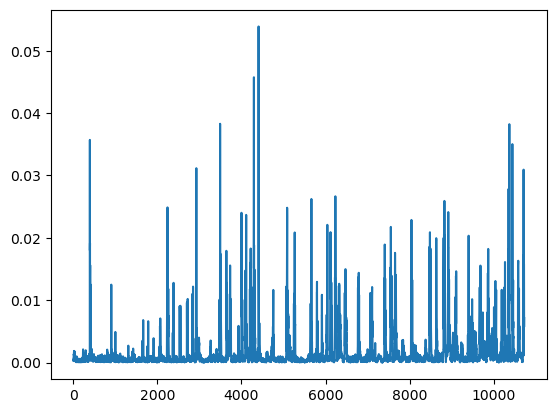

In [98]:
pupil = raw_data.get_column("pupil_r_thresholded").to_numpy()
timestamp = raw_data.get_column("timestamp").to_numpy()

pupil_diff = np.diff(pupil)
timestamp_diff = np.diff(timestamp)

rates = pupil_diff / timestamp_diff
rates = np.abs(pupil_diff / timestamp_diff)
rates

d_prime = np.maximum(rates[:-1], rates[1:])
d_prime

plt.plot(d_prime)
d_prime

In [62]:
pupil_size = raw_data.get_column("pupil_r_thresholded").to_numpy()
timestamps = raw_data.get_column("timestamp").to_numpy()

# Step 1: Calculate dilation speed
dilation_speed = np.abs(np.diff(pupil_size) / np.diff(timestamps))
dilation_speed = np.maximum.reduceat(dilation_speed, range(0, len(dilation_speed), 2))

# Step 2: Identify dilation speed outliers
mad = np.median(np.abs(dilation_speed - np.median(dilation_speed)))
threshold = np.median(dilation_speed) + 3 * mad  # Adjust the multiplier as needed
valid_samples = dilation_speed < threshold

ic(dilation_speed, threshold, mad, valid_samples)

ic| dilation_speed: array([0.00045223, 0.00045536, 0.00032144, ..., 0.00985491, 0.00713178,
                           0.00636044])
    threshold: np.float64(0.0018344465263589451)
    mad: np.float64(0.0003884835036514806)
    valid_samples: array([ True,  True,  True, ..., False, False, False])


(array([0.00045223, 0.00045536, 0.00032144, ..., 0.00985491, 0.00713178,
        0.00636044]),
 np.float64(0.0018344465263589451),
 np.float64(0.0003884835036514806),
 array([ True,  True,  True, ..., False, False, False]))

In [64]:
def calculate_d_prime(d, t):
    """
    Vectorized calculation of dilation speed series d'.

    Parameters:
    d (list or array): Data points array.
    t (list or array): Time points array.

    Returns:
    numpy.ndarray: The dilation speed series d'.
    """
    d = np.array(d)
    t = np.array(t)

    # Calculate differences in d and t
    d_diff = np.diff(d)  # d[i+1] - d[i]
    t_diff = np.diff(t)  # t[i+1] - t[i]

    # Avoid division by zero and calculate rates of change
    rates = np.abs(d_diff / t_diff)

    # Calculate max of rates[i-1] and rates[i] for each valid i
    d_prime = np.maximum(rates[:-1], rates[1:])

    return d_prime


def calculate_mad_and_threshold(d_prime, n):
    """
    Calculate the Median Absolute Deviation (MAD) and the threshold for outlier detection.

    Parameters:
    d_prime (numpy.ndarray): The dilation speed series d'.
    n (float): The constant multiplier for MAD.

    Returns:
    tuple: A tuple containing the MAD and the threshold.
    """
    mad = np.median(np.abs(d_prime - np.median(d_prime)))
    threshold = np.median(d_prime) + n * mad

    return mad, threshold


# # Example data
d = pupil_size
t = timestamps
n = 16  # as in code dilationSpeedFilter_MadMultiplier


# Calculate d' (dilation speed series)
d_prime = calculate_d_prime(d, t)

# Calculate MAD and threshold
mad, threshold = calculate_mad_and_threshold(d_prime, n)

d_prime, mad, threshold

(array([0.00045223, 0.00045536, 0.00045536, ..., 0.00570251, 0.00713178,
        0.00713178]),
 np.float64(0.00039479518391534343),
 np.float64(0.00699055987281966))

In [ ]:
plt.plot(d_prime)
# x in log
plt.yscale("log")
# add horizontal line for threshold
plt.axhline(threshold, color="red", linestyle="--")